In [4]:
import pickle
import itertools
import networkx as nx
import numpy as np
from numpy import dot
from numpy.linalg import norm

# import matplotlib.pyplot as plt
import spacy 

import re 

with open('./dataset/ext_val.pickle', 'rb') as f:
    dataset = pickle.load(f)

In [5]:
len(dataset)

13368

In [6]:
article = [' '.join(src['src']) for src in dataset[1]]



In [11]:
article

['( cnn ) another kardashian heard from .',
 'usually the kardashian - industrial complex is dominated by comments and social media postings from kim , followed closely by khloe and perhaps one of the jenner children .',
 'but on sunday , it was rob , the youngest of the four kardashian siblings , who drew most of the attention .',
 'in an instagram post , rob kardashian compared his sister to the sociopathic amy dunne , the murderous wife played by rosamund pike in " gone girl . "',
 '" my sister kim , the b **** from gone girl , , , " he posted .',
 "he accompanied the text with a photo of pike 's character drenched in blood , fresh from ( spoiler alert ! )",
 'killing her ex-boyfriend .',
 'he also unfollowed his entire family , though he changed his mind later .',
 "it 's not the first time rob has been at odds with the heavily spotlighted kardashian clan .",
 "he missed out on kim 's wedding to kanye west , with various ( unnamed , of course ) gossip sources reporting at the time 

In [12]:
nlp = spacy.load("en_core_web_sm")

key_word = {}
tag_list = ['NN', 'JJ', 'NNP']


for sent in article:
    results = nlp(sent)
    for result in results:
        if (result.tag_ in tag_list) and (result.text not in key_word):
            key_word[result.text] = result.vector

In [13]:
unique_vocab = set()
add_vocab = unique_vocab.add
for element in [x for x in key_word if x not in unique_vocab]:
    add_vocab(element)

In [14]:
%time

nodes = unique_vocab
min_sim = 0.3
gr = nx.Graph()  # initialize an undirected graph
gr.add_nodes_from(nodes)

nodePairs = list(itertools.combinations(nodes, 2))



# add edges to the graph (weighted by Levenshtein distance)
for pair in nodePairs:
    node1 = pair[0]
    node2 = pair[1]
    
    cos_sim = dot(key_word[pair[0]], key_word[pair[1]]) / (norm(key_word[pair[0]])*norm(key_word[pair[1]]))
    
    if cos_sim  > min_sim:
        gr.add_edge(node1, node2, weight = cos_sim)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


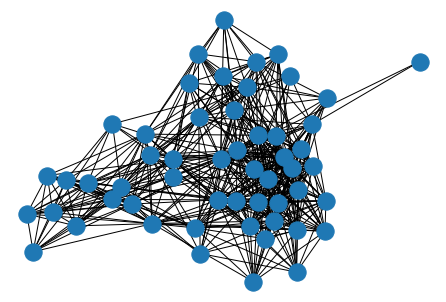

In [15]:
%matplotlib inline

nx.draw(gr)
plt.show()

In [76]:
word_set_list = list(unique_vocab)
textlist = list(key_word.keys())

calculated_page_rank = nx.pagerank(gr, alpha=0.85, max_iter =100 ,weight='weight') #alpha means damping factor

# most important words in ascending order of importance
keyphrases = sorted(calculated_page_rank, key=calculated_page_rank.get,
                reverse=True)
# the number of keyphrases returned will be relative to the size of the
# text (a third of the number of vertices)

one_third = len(word_set_list) // 3
keyphrases = keyphrases[0:one_third + 1]

modified_key_phrases = set([])

dealt_with = set([])
i = 0
j = 1
while j < len(textlist):
    first = textlist[i]
    second = textlist[j]
    if first in keyphrases and second in keyphrases:
        keyphrase = first + ' ' + second
        modified_key_phrases.add(keyphrase)
        dealt_with.add(first)
        dealt_with.add(second)
    else:
        if first in keyphrases and first not in dealt_with:
            modified_key_phrases.add(first)

        # if this is the last word in the text, and it is a keyword, it
        # definitely has no chance of being a keyphrase at this point
        if j == len(textlist) - 1 and second in keyphrases and \
                second not in dealt_with:
            modified_key_phrases.add(second)

    i = i + 1
    j = j + 1
len(modified_key_phrases)

15

In [88]:
import statistics
new_extract = {}
for vocab in list(modified_key_phrases):
    if vocab not in calculated_page_rank:
        new = vocab.split()
        new_score = [calculated_page_rank[n] for n in new]
        new_extract[vocab] = statistics.mean(new_score)
    else: 
        new_extract[vocab] =calculated_page_rank[vocab]

resul = sorted(new_extract, key=new_extract.get,reverse=True)[:3]
resul

['spoiler', 'year', 'entire family']

# Sentence

In [26]:
article = [' '.join(src['src']) for src in dataset[1]]
sentence = {}

for sent in article:
    results = nlp(sent.strip())
    

In [27]:
def make_sentence_graph(sentence, min_sim):
    sentence_graph = nx.Graph()  # initialize an undirected graph
    sentence_graph.add_nodes_from(sentence)

    nodePairs = list(itertools.combinations(sentence, 2))

    # add edges to the graph (weighted by Levenshtein distance)
    for pair in nodePairs:
        node1 = pair[0]
        node2 = pair[1]

        cos_sim = dot(sentence[pair[0]][1], sentence[pair[1]][1]) / (
            norm(sentence[pair[0]][1]) * norm(sentence[pair[1]][1])
        )

        if cos_sim > min_sim:
            sentence_graph.add_edge(node1, node2, weight=cos_sim)

    return sentence_graph

In [28]:
for idx, sent in enumerate(article):
    re_sent = re.sub(r"[^\.\?\!\w\d\s]", "", sent)
    results = nlp(re_sent)

    sentence_vector = [result.vector for result in results]
    sentence[sent] = [idx, np.mean(sentence_vector, axis=0)]

sentence_graph = make_sentence_graph(sentence,min_sim = 0.4)

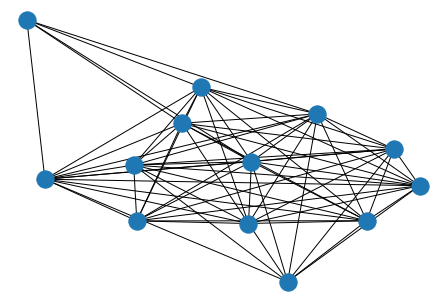

In [29]:
%matplotlib inline

nx.draw(sentence_graph)
plt.show()

In [30]:
calculated_page_rank = nx.pagerank(
        sentence_graph, alpha=0.85, max_iter=100, weight="weight"
    )
    
sentences = sorted(calculated_page_rank, key=calculated_page_rank.get,
                   reverse=True)

In [46]:
top_k = 3
modified_sentence = sentences[: -len(sentences)+top_k]
result_sentence = [(sentence[sent][0],sent) for sent in modified_sentence]

result_sentence

[(9,
  "he missed out on kim 's wedding to kanye west , with various ( unnamed , of course ) gossip sources reporting at the time that he was n't getting along with members of his family ."),
 (5,
  "he accompanied the text with a photo of pike 's character drenched in blood , fresh from ( spoiler alert ! )"),
 (3,
  'in an instagram post , rob kardashian compared his sister to the sociopathic amy dunne , the murderous wife played by rosamund pike in " gone girl . "')]

In [192]:
for i,v in enumerate(dataset[5]):
    if v['score'] == 1:
        print(i)
        

In [188]:
dataset[1]

[{'src': ['(', 'cnn', ')', 'another', 'kardashian', 'heard', 'from', '.'],
  'score': 0},
 {'src': ['usually',
   'the',
   'kardashian',
   '-',
   'industrial',
   'complex',
   'is',
   'dominated',
   'by',
   'comments',
   'and',
   'social',
   'media',
   'postings',
   'from',
   'kim',
   ',',
   'followed',
   'closely',
   'by',
   'khloe',
   'and',
   'perhaps',
   'one',
   'of',
   'the',
   'jenner',
   'children',
   '.'],
  'score': 0},
 {'src': ['but',
   'on',
   'sunday',
   ',',
   'it',
   'was',
   'rob',
   ',',
   'the',
   'youngest',
   'of',
   'the',
   'four',
   'kardashian',
   'siblings',
   ',',
   'who',
   'drew',
   'most',
   'of',
   'the',
   'attention',
   '.'],
  'score': 0},
 {'src': ['in',
   'an',
   'instagram',
   'post',
   ',',
   'rob',
   'kardashian',
   'compared',
   'his',
   'sister',
   'to',
   'the',
   'sociopathic',
   'amy',
   'dunne',
   ',',
   'the',
   'murderous',
   'wife',
   'played',
   'by',
   'rosamund',
   '